In this section, we install all the required libraries using `pip`. These include:

- `torch`: PyTorch, the deep learning framework.
- `torchvision`: A package that provides access to datasets and image transformation functions.
- `matplotlib`: A library to visualize images.

We install these libraries to ensure that the environment is set up correctly for model training and testing.


In [1]:
# Install the required libraries

#!pip install torch torchvision matplotlib  

Here, we import the necessary libraries for building the CNN model:

- `torch` and `torch.nn`: For building and training the neural network.
- `torch.optim`: For optimization algorithms.
- `torchvision`: For dataset and transformations.
- `matplotlib.pyplot`: For visualizing sample images from the dataset.


In [23]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy



In this step, we load the CIFAR-10 dataset using `torchvision.datasets.CIFAR10`. 

- **Training and Test Sets**: CIFAR-10 is split into a training set (50,000 images) and a test set (10,000 images).
- **Transformations**: 
  - `ToTensor`: Converts images to PyTorch tensors.
  - `Normalize`: Normalizes the pixel values to the range [-1, 1].
- **DataLoader**: Handles batch processing and shuffling of data during training and testing.

The batch size is set to 32, and shuffling is enabled for the training set to improve training efficiency.


In [24]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


We define a function to display a batch of 10 sample images along with their labels.

- **Normalization Reversal**: The images are normalized during preprocessing. To display them, we unnormalize them.
- **Visualization**: `matplotlib` is used to plot the images, and their corresponding labels are displayed.


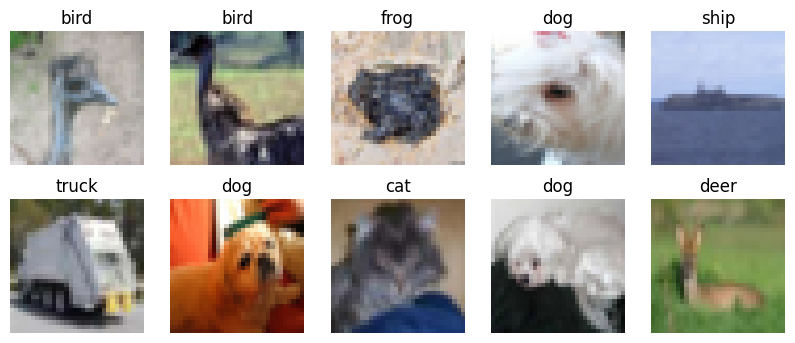

In [25]:
# Display some sample images
def show_images(images, labels):
    """Function to display images"""
    class_names = trainset.classes
    images = images / 2 + 0.5  # unnormalize
    plt.figure(figsize=(10, 4))
    for idx in range(10):
        plt.subplot(2, 5, idx + 1)
        plt.imshow(images[idx].permute(1, 2, 0))
        plt.title(class_names[labels[idx]])
        plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
show_images(images, labels)


We define a simple CNN model with the following layers:

- **Convolutional Layers**: Two convolutional layers with ReLU activation, using 3x3 filters.
- **Pooling Layers**: Max pooling layers to reduce the spatial dimensions of the feature maps.
- **Fully Connected Layers**: Two dense layers:
  - First layer with 512 neurons.
  - Second layer with 10 neurons (one for each CIFAR-10 class).

The `forward` method specifies the forward pass of the input through the network.


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        
        # Convolutional layers with BatchNorm
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected layer
        self.fc1 = nn.Linear(256, 128)  # Adjusted after GAP
        self.fc2 = nn.Linear(128, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        # Convolutional layers with ReLU, BatchNorm, and Pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Global Average Pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        
        # Flatten for the fully connected layer
        x = torch.flatten(x, 1)
        
        # Fully connected layers with Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [29]:
model = EnhancedCNN()

We use the following:

- **Loss Function**: `CrossEntropyLoss`, which is suitable for multi-class classification.
- **Optimizer**: Adam optimizer, which adapts the learning rate dynamically during training.


In [30]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


The training process involves:

1. **Zeroing Gradients**: Reset the gradients before each training step.
2. **Forward Pass**: Compute the predictions for the inputs.
3. **Loss Computation**: Calculate the loss using the ground truth labels.
4. **Backward Pass**: Compute the gradients.
5. **Optimizer Step**: Update the weights.

The training runs for 10 epochs.


In [31]:
# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Training Error: {running_loss / len(trainloader)}")


Epoch 1, Training Error: 1.4820587292590053
Epoch 2, Training Error: 1.1866065588656405
Epoch 3, Training Error: 1.0588414183771924
Epoch 4, Training Error: 0.9586270934331897
Epoch 5, Training Error: 0.8788619946571626
Epoch 6, Training Error: 0.8128055742705242
Epoch 7, Training Error: 0.7537996336312456
Epoch 8, Training Error: 0.6998641656345842
Epoch 9, Training Error: 0.6422397564674751
Epoch 10, Training Error: 0.5945060836414611


# **Model Evaluation and Metrics**

This section evaluates the trained model on the test dataset using various classification metrics. The code calculates accuracy, F1 score, precision, and recall, and provides a detailed classification report.

---

## **Code Explanation**

1. **Model Evaluation**:
   - Ensures the model is in evaluation mode using `model.eval()`.
   - Uses `torch.no_grad()` to avoid tracking gradients during inference, improving performance.

2. **Prediction Collection**:
   - Loops through the test dataset.
   - Collects true labels and predictions for later evaluation.

3. **Metrics Calculation**:
   - **Accuracy**: Overall percentage of correct predictions.
   - **F1 Score**: Weighted balance between precision and recall.
   - **Precision**: Proportion of correctly predicted positive cases.
   - **Recall**: Proportion of actual positives correctly identified.
   - **Classification Report**: Detailed per-class metrics.

4. **Results Display**:
   - Prints all metrics with appropriate formatting.
   - Outputs a detailed classification report.

---

## **Metrics and Results**

```plaintext
Accuracy: <calculated_accuracy>%
F1 Score: <calculated_f1_score>
Precision: <calculated_precision>
Recall: <calculated_recall>

Detailed Classification Report:

<classification_report_output>


In [ ]:

from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import numpy as np

# Testing the model
model.eval()  # Ensure the model is in evaluation mode

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images, labels  # Move data to device
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.extend(labels.cpu().numpy())  # Store labels
        all_predictions.extend(predicted.cpu().numpy())  # Store predictions

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Metrics Calculation
accuracy = accuracy_score(all_labels, all_predictions) * 100
f1 = f1_score(all_labels, all_predictions, average="weighted")  # Weighted F1-score
precision = precision_score(all_labels, all_predictions, average="weighted")  # Weighted Precision
recall = recall_score(all_labels, all_predictions, average="weighted")  # Weighted Recall

# Detailed Classification Report
report = classification_report(all_labels, all_predictions, target_names=[str(i) for i in range(10)])

# Print Metrics
print(f"Accuracy: {accuracy:.2f}%")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("\nDetailed Classification Report:\n")
print(report)



Accuracy: 77.92%
F1 Score: 0.78
Precision: 0.78
Recall: 0.78

Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1000
           1       0.85      0.93      0.89      1000
           2       0.69      0.69      0.69      1000
           3       0.59      0.59      0.59      1000
           4       0.80      0.68      0.73      1000
           5       0.66      0.71      0.69      1000
           6       0.75      0.88      0.81      1000
           7       0.92      0.76      0.83      1000
           8       0.86      0.91      0.89      1000
           9       0.92      0.82      0.87      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



The model's parameters (weights and biases) are saved to a file (`cnn_cifar10.pth`). This file can be used to reload the model for inference or further training.


In [ ]:
# Save the model
torch.save(model.state_dict(), 'cnn_cifar10.pth')
